In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from envs.env import *
import pandas as pd
from config import settings
import pickle
from constants import MAB_FEATURE_NAMES

RESTART_data = True
RESTART = True 

## Open Data

In [3]:
catalog_df = pd.read_parquet("data/whatson_catalog_df.parquet")
historical_data_df = pd.read_pickle("data/historical_data_df.pkl")
with open(settings.aud_model_dir/"rf_model.pkl", "rb") as f:    # load frozen viewership model
    audience_model = pickle.load(f)

In [4]:
historical_data_df['catalog_id'] = historical_data_df['catalog_id'].astype('Int64')

In [5]:
historical_data_df['catalog_id'].value_counts()

catalog_id
-1        18
796648     6
916373     4
881770     4
763285     3
          ..
935160     1
395993     1
868522     1
15120      1
43799      1
Name: count, Length: 1337, dtype: Int64

In [6]:
id = 762504
historical_data_df[historical_data_df['catalog_id'] == id]

,title,date,content_class_key,channel,duration_min,hour,day,weekday,is_weekend,month,rt_m,tmdb_id,season,processed_title,missing_tmdb_id,catalog_id
40406,Nope,2024-07-17,71,RTS 1,123.116667,22,17,2,False,7,16.8,762504.0,summer,Nope,False,762504
41286,NOPE,2024-07-21,AAD,France 2,126.583333,22,21,6,True,7,8.0,762504.0,summer,Nope,False,762504
48180,NOPE,2024-08-18,AAD,France 2,27.016667,25,18,6,True,8,2.2,762504.0,summer,Nope,False,762504


## Prepare Environment

In [7]:
env = TVProgrammingEnvironment(movie_catalog=catalog_df,
                         historical_df= historical_data_df,
                         audience_model=audience_model,
                         reward_weights= None)

Setting up CompetitorDataManager...
Setting up Scalers...
Setting up RewardCalculator...


In [8]:
temp = env.competitor_manager.competitor_historical_data
temp[temp['catalog_id'] == 762504]
movie_competitor_context = env.competitor_manager.get_movie_competitor_context(762504, reference_date='2024-07-17')
movie_competitor_context.competitor_showings

[{'channel': 'France 2', 'air_date': '2024-07-21', 'air_hour': 22}]

In [9]:
from IL_training import *

hist_data_processor = HistoricalDataProcessor(environment=env)

## Prepare Traing Data

competitive_showings = [771077, 398920, 398920, 770554, 594691, 455446, 658905, 745589, 838916, 546554, 925102, 880728, 1149095, 762504, 446354, 768127]

In [10]:
env.movie_catalog

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown,info_score
catalog_id,,,,,,,,,,,,,,,,,,,,,
220,A l'est d'eden,"James Dean, Julie Harris, Raymond Massey, Rich...",False,0.0,A l'est d'éden,1.0,71,1995-05-26,1998-12-24,1998-12-24,...,220.0,1.0,0,7.600,True,False,True,70,0,40
12155,Alice au pays des merveilles,None,False,2.0,Alice au pays des merveilles,0.0,71,None,None,None,...,12155.0,2.0,0,6.635,True,False,True,15,0,33
XF_000_0,Rocket a monte carlo,None,False,3.0,Amicalement votre,0.0,71,None,None,None,...,NaN,3.0,0,0.000,True,True,True,125,0,32
11806,Beethoven,"Charles Grodin, Bonnie Hunt, Dean Jones, Tom N...",False,3.0,Beethoven,0.0,71,None,None,None,...,11806.0,3.0,0,5.830,True,False,True,33,0,37
279332,Bonne fete maman,None,False,2.0,Bonne fête maman,0.0,71,None,None,None,...,279332.0,2.0,0,5.900,True,False,True,11,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XF_000_460,Séparation dangereuse,"Ulrich Tukur, Annett Renneberg, Peter Fitz, Su...",False,1.0,Téléfilm,1.0,71,1999-10-08,2002-03-23,2002-03-23,...,NaN,2.0,0,0.000,True,True,True,125,0,39
XF_000_461,La vie d'un basketteur hors du commun,"Dwayne Adway, John Terry, Dee Wallace-Stone",False,1.0,Téléfilm,1.0,71,2002-03-17,2002-03-17,None,...,NaN,2.0,0,0.000,True,True,True,125,0,38
733369,De gré ou de force,"Laurent Arnal, Marie Desgranges, Philippe Faur...",False,1.0,Téléfilm,1.0,71,1999-03-19,2001-12-08,2001-12-08,...,733369.0,2.0,0,5.500,True,False,True,26,0,39


In [12]:
if RESTART_data:
    training_data, all_rewards, movies_not_found = hist_data_processor.prepare_training_data(channel_name='RTS 1')

Processing historical programming data...
Found 973 programming decisions for RTS 1


Processing rows: 100%|██████████| 973/973 [03:05<00:00,  5.25it/s]

Created 973 positive samples


In [13]:
a = hist_data_processor.env.movie_catalog.copy()
a[a['times_shown'] > 0]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown,info_score
catalog_id,,,,,,,,,,,,,,,,,,,,,
744941.0,Cher Noël,,False,NaN,NaN,NaN,72,NaN,NaN,NaN,...,744941.0,NaN,NaN,6.500,True,False,True,4,1,NaN
36670.0,James Bond: Jamais plus jamais,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,36670.0,NaN,NaN,6.051,True,False,True,41,1,NaN
746333.0,Super-héros malgré lui,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,746333.0,NaN,NaN,6.400,True,False,True,3,1,NaN
262391.0,Qu'est-ce qu'on a fait au Bon Dieu ?,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,262391.0,NaN,NaN,6.665,True,False,True,11,1,NaN
459992.0,Séduis-moi si tu peux,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,459992.0,NaN,NaN,6.726,True,False,True,6,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95363.0,LE MIRACLE DES LOUPS,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,95363.0,NaN,NaN,5.800,True,False,True,63,1,NaN
1025208.0,Rencard avec le diable,,False,NaN,NaN,NaN,72,NaN,NaN,NaN,...,1025208.0,NaN,NaN,6.500,True,False,True,2,1,NaN
356326.0,What We Become,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,356326.0,NaN,NaN,5.500,True,False,True,9,1,NaN


In [14]:
import pickle
from pathlib import Path

TRAINING_PATH = Path("data/IL_data/training_data.pkl")
REWARDS_PATH = Path("data/IL_data/all_rewards.pkl")
MISSING_PATH = Path("data/IL_data/movies_not_found.pkl")

if RESTART_data:
    TRAINING_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(TRAINING_PATH, "wb") as f:
        pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(REWARDS_PATH, "wb") as f:
        pickle.dump(all_rewards, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(MISSING_PATH, "wb") as f:
        pickle.dump(movies_not_found, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(TRAINING_PATH, "rb") as f:
        training_data = pickle.load(f)

    with open(REWARDS_PATH, "rb") as f:
            all_rewards = pickle.load(f)

    with open(MISSING_PATH, "rb") as f:
            movies_not_found = pickle.load(f)


In [15]:
hist_data_processor.env.movie_catalog.loc['1000094']

title                                                             Le clan
actors                  Eric Fraticelli, Philippe Corti, Jean-François...
adult                                                               False
available_num_diff                                                    2.0
collection                                                           Film
consumed_num_diff                                                     0.0
content_class_key                                                      71
date_diff_1                                                          None
date_last_diff                                                       None
date_rediff_1                                                        None
date_rediff_2                                                        None
date_rediff_3                                                        None
date_rediff_4                                                        None
department                            

## Visualize Reward Distributions

In [16]:
np.median(training_data['reward_targets'])

0.7232310243165083

In [17]:
reward_audience = [d['audience'] for d in all_rewards]
reward_competition = [d['competition'] for d in all_rewards]
reward_diversity = [d['diversity'] for d in all_rewards]
reward_novelty = [d['novelty'] for d in all_rewards]
reward_rights = [d['rights'] for d in all_rewards]

In [18]:
def show_specs(signal):
    minimum = np.min(signal)
    maximum = np.max(signal)
    median  = np.median(signal)
    mean    = np.mean(signal)
    q1      = np.percentile(signal, 25)
    q3      = np.percentile(signal, 75)
    iqr     = q3 - q1

    print(f"Min:    {minimum}")
    print(f"Q1:     {q1}")
    print(f"Median: {median}")
    print(f"Q3:     {q3}")
    print(f"Max:    {maximum}")
    print(f"IQR:    {iqr}")
    print(f"Mean:   {mean}")

In [19]:
print('------Total Rewards----------')
show_specs(training_data['reward_targets'])

------Total Rewards----------
Min:    0.7025301909521544
Q1:     0.7151607742421547
Median: 0.7232310243165083
Q3:     0.7315646276526617
Max:    0.8990100133427477
IQR:    0.016403853410506986
Mean:   0.7307529088781298


In [20]:
print('------Audience----------')
show_specs(reward_audience)
print('\n------Competition----------')
#show_specs([x for x in reward_competition if x > 0])
show_specs(reward_competition)
print('\n------Diversity----------')
show_specs(reward_diversity)
print('\n------Novelty----------')
show_specs(reward_novelty)
print('\n------Rights----------')
show_specs(reward_rights)

------Audience----------
Min:    0.010512483574244415
Q1:     0.05716162943495401
Median: 0.1314060446780552
Q3:     0.18002628120893563
Max:    1.0000000000000002
IQR:    0.12286465177398162
Mean:   0.1612431849151803

------Competition----------
Min:    0.0
Q1:     0.0
Median: 0.0
Q3:     0.0
Max:    0.8032653298563167
IQR:    0.0
Mean:   0.016692307763028102

------Diversity----------
Min:    0.3
Q1:     0.5322608442091599
Median: 0.5828697230006558
Q3:     0.6473729651520237
Max:    0.8206659674885375
IQR:    0.11511212094286383
Mean:   0.5988115206479859

------Novelty----------
Min:    1.0
Q1:     1.0
Median: 1.0
Q3:     1.0
Max:    1.0
IQR:    0.0
Mean:   1.0

------Rights----------
Min:    0
Q1:     0.0
Median: 0.0
Q3:     0.0
Max:    0
IQR:    0.0
Mean:   0.0


## Training

In [21]:
import torch

context_np = training_data['context_features']  # numpy array
movie_np = training_data['movie_features']      # numpy array

# Convert to tensors
context_tensor = torch.from_numpy(context_np)
movie_tensor = torch.from_numpy(movie_np)

# Check for NaNs
print("Context NaNs:", torch.isnan(context_tensor).any().item())
print("Movie NaNs:", torch.isnan(movie_tensor).any().item())


Context NaNs: False
Movie NaNs: False


In [22]:
if RESTART:
    # Initialize trainer
    trainer = NetworkTrainer()
    # Train Curator Network
    curator_model = trainer.train_curator_network(
        training_data=training_data,
        epochs=1000,
        batch_size=256,
        learning_rate=0.001
    )

Training Curator Network...


Epoch 0: Loss=0.7040
Epoch 10: Loss=0.0000
Epoch 20: Loss=0.0000
Epoch 30: Loss=0.0000
Epoch 40: Loss=0.0000
Epoch 50: Loss=0.0000
Epoch 60: Loss=0.0000
Epoch 70: Loss=0.0000
Epoch 80: Loss=0.0000
Epoch 90: Loss=0.0000
Epoch 100: Loss=0.0000
Epoch 110: Loss=0.0000
Epoch 120: Loss=0.0000
Epoch 130: Loss=0.0000
Epoch 140: Loss=0.0000
Epoch 150: Loss=0.0000
Epoch 160: Loss=0.0000
Epoch 170: Loss=0.0000
Epoch 180: Loss=0.0000
Epoch 190: Loss=0.0000
Epoch 200: Loss=0.0000
Epoch 210: Loss=0.0000
Epoch 220: Loss=0.0000
Epoch 230: Loss=0.0000
Epoch 240: Loss=0.0000
Epoch 250: Loss=0.0000
Epoch 260: Loss=0.0000
Epoch 270: Loss=0.0000
Epoch 280: Loss=0.0000
Epoch 290: Loss=0.0000
Epoch 300: Loss=0.0000
Epoch 310: Loss=0.0000
Epoch 320: Loss=0.0000
Epoch 330: Loss=0.0000
Epoch 340: Loss=0.0000
Epoch 350: Loss=0.0000
Epoch 360: Loss=0.0000
Epoch 370: Loss=0.0000
Epoch 380: Loss=0.0000
Epoch 390: Loss=0.0000
Epoch 400: Loss=0.0000
Epoch 410: Loss=0.0000
Epoch 420: Loss=0.0000
Epoch 430: Loss=0.0000

In [23]:
if RESTART:
    # Train Reward Model
    reward_model = trainer.train_reward_model(
        training_data=training_data,
        epochs=1000,
        batch_size=256,
        learning_rate=0.001
    )

Training Reward Model...
Epoch 0: Loss=0.0530
Epoch 10: Loss=0.0017
Epoch 20: Loss=0.0012
Epoch 30: Loss=0.0010
Epoch 40: Loss=0.0010
Epoch 50: Loss=0.0008
Epoch 60: Loss=0.0009
Epoch 70: Loss=0.0008
Epoch 80: Loss=0.0007
Epoch 90: Loss=0.0007
Epoch 100: Loss=0.0007
Epoch 110: Loss=0.0007
Epoch 120: Loss=0.0007
Epoch 130: Loss=0.0007
Epoch 140: Loss=0.0006
Epoch 150: Loss=0.0007
Epoch 160: Loss=0.0007
Epoch 170: Loss=0.0006
Epoch 180: Loss=0.0007
Epoch 190: Loss=0.0007
Epoch 200: Loss=0.0006
Epoch 210: Loss=0.0006
Epoch 220: Loss=0.0006
Epoch 230: Loss=0.0007
Epoch 240: Loss=0.0007
Epoch 250: Loss=0.0007
Epoch 260: Loss=0.0007
Epoch 270: Loss=0.0007
Epoch 280: Loss=0.0007
Epoch 290: Loss=0.0006
Epoch 300: Loss=0.0007
Epoch 310: Loss=0.0006
Epoch 320: Loss=0.0006
Epoch 330: Loss=0.0007
Epoch 340: Loss=0.0006
Epoch 350: Loss=0.0006
Epoch 360: Loss=0.0007
Epoch 370: Loss=0.0006
Epoch 380: Loss=0.0007
Epoch 390: Loss=0.0006
Epoch 400: Loss=0.0006
Epoch 410: Loss=0.0007
Epoch 420: Loss=0.00

## Save models

In [24]:

context_features = training_data['context_features']
movie_features = np.squeeze(training_data['movie_features'])
context_dim = context_features.shape[1]
movie_dim = movie_features.shape[1]

In [25]:
movie_features.shape

(973, 23)

In [26]:
if RESTART:
    # Save models
    torch.save(curator_model.state_dict(), 'models/curator_model.pth')
    torch.save(reward_model.state_dict(), 'models/reward_model.pth')

else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Initialize model
    curator_model = CuratorNetwork(context_dim, movie_dim).to(device)
    curator_model.load_state_dict(torch.load('models/curator_model.pth'))

In [27]:
print(context_dim)
print(movie_dim)

16
23


## Prepare training Data for TS

In [28]:
aud_reward_features = np.array(reward_audience).reshape(-1,1)
comp_reward_features = np.array(reward_competition).reshape(-1,1)
div_reward_features = np.array(reward_diversity).reshape(-1,1)
nov_reward_features = np.array(reward_novelty).reshape(-1,1)
rights_reward_features = np.array(reward_rights).reshape(-1,1)

In [29]:
#X_hist = np.concatenate((context_features, movie_features, aud_reward_features, comp_reward_features, div_reward_features, nov_reward_features, rights_reward_features), axis = 1)
interaction_features = []
for i in range(len(context_features)):
    if i == 4:
        interaction_feature, interaction_feature_names = env.build_context_movie_interactions(context_features[i], movie_features[i])
    else:
        interaction_feature, _ = env.build_context_movie_interactions(context_features[i], movie_features[i])
    interaction_features.append(interaction_feature)
interaction_features = np.array(interaction_features)


print(interaction_features.shape)


    

(973, 368)


In [30]:
X_hist = np.concatenate((interaction_features, aud_reward_features, comp_reward_features, div_reward_features, nov_reward_features, rights_reward_features), axis = 1)
R_hist = training_data['reward_targets'] # Use pseudo-rewards to nudge the Bayesain model in a desired direction
print(X_hist.shape)
print(R_hist.shape)

(973, 373)
(973,)


## Seeding

In [31]:
np.random.seed(42) 

In [32]:
from thompson import ThompsonSampler

ts = ThompsonSampler(dim=X_hist.shape[1], lam=1.0, sigma=1.0)
ts.warm_start(X_hist, R_hist)


## Show weight distributions

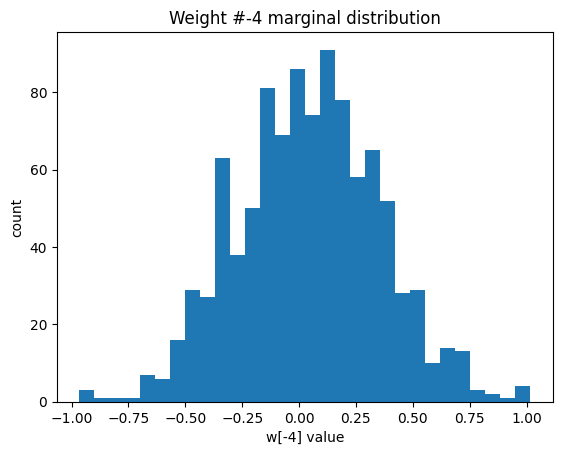

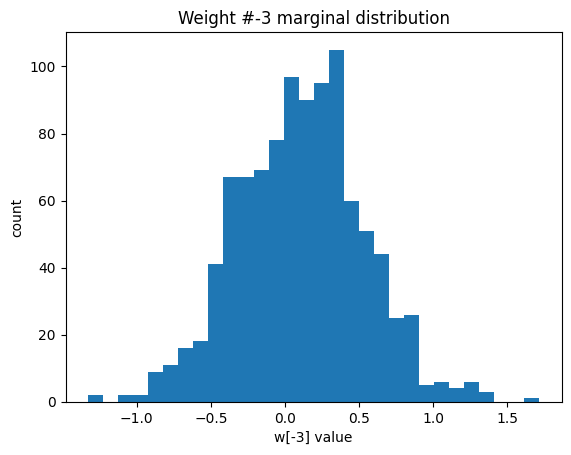

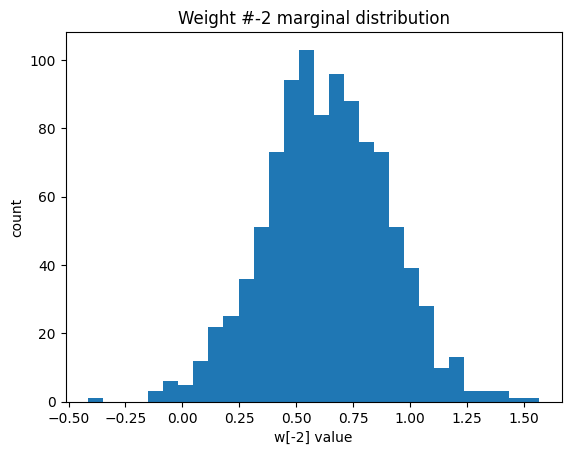

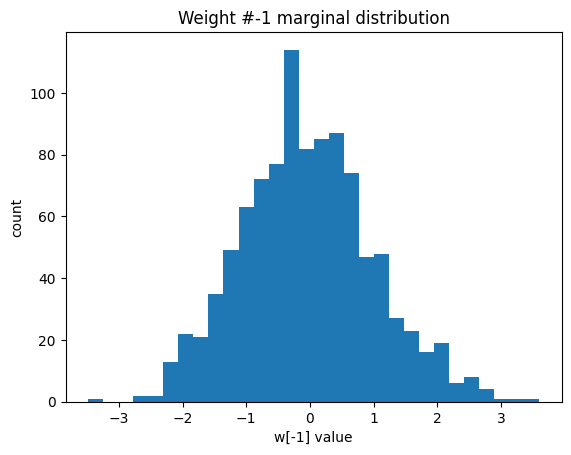

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ————————————————————————————————
# 1) Draw many posterior samples
# ————————————————————————————————
# Assume `ts` is your ThompsonSampler instance
# and ts.sample_weights() returns (w_sample, mu, cov)
num_samples = 1000
all_w = np.vstack([
    ts.sample_weights()
    for _ in range(num_samples)
])  # shape = (num_samples, d)

# ————————————————————————————————
# 2) Plot marginal histograms for each weight
# ————————————————————————————————
for i in range(-4, 0):
    plt.figure()
    plt.hist(all_w[:, i], bins=30)
    plt.title(f"Weight #{i} marginal distribution")
    plt.xlabel(f"w[{i}] value")
    plt.ylabel("count")
    plt.show()


In [34]:
MAB_FEATURE_NAMES[-4:]

['reward_competition', 'reward_diversity', 'reward_novelty', 'reward_rights']

## Test recommendations

In [35]:
date = '2025-08-04'
air_date = utils.date_formatting.to_datetime_format(date)
hour = 21
context = env.create_context_from_date(date, hour)
print(context)

Context(hour=21, day_of_week=0, month=8, season=<Season.SUMMER: 'summer'>)


In [36]:
env.competitor_manager.update_competition_historical_data() # scrape future shwoings and add to historical data

[datetime.date(2025, 8, 9), datetime.date(2025, 8, 16), datetime.date(2025, 8, 23)]


Weeks for TF1: 100%|██████████| 3/3 [00:24<00:00,  8.20s/it]


Failed to scrape TF1: 404 Client Error: Not Found for url: https://tf1pro.com/grilles-xml/16/2025-08-23


Weeks for M6: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Failed to scrape M6: 404 Client Error:  for url: https://pro.m6.fr/m6/grille/2025-35.xml


In [37]:
a = env.competitor_manager.competitor_historical_data
a

,title,date,content_class_key,channel,duration_min,hour,day,weekday,is_weekend,month,rt_m,tmdb_id,season,processed_title,missing_tmdb_id,catalog_id
106,SCOOBY-DOO ET LE FANTOME GOURMAND,2024-01-01,ABM,France 3,74.116667,8,1,0,False,1,0.4,533592.0,winter,Scooby-Doo! et le fantôme gourmand,False,533592
130,FORT BRAVO,2024-01-01,AAH,France 3,94.883333,13,1,0,False,1,7.2,83099.0,winter,Fort Bravo,False,83099
140,NORMANDIE NUE,2024-01-01,AAF,France 3,105.383333,21,1,0,False,1,15.9,492550.0,winter,Normandie Nue,False,492550
141,BRAQUAGE A L ANCIENNE,2024-01-01,AAA,France 3,92.783333,22,1,0,False,1,9.5,353070.0,winter,Braquage à l'ancienne,False,353070
277,ARNAQUE A HOLLYWOOD,2024-01-02,ABA,France 2,97.616667,13,2,1,False,1,9.8,650783.0,winter,Arnaque à Hollywood,False,650783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,Juste ciel !,2025-08-15 00:00:00,71,M6,87.000000,21,15,4,False,8,0.0,885243.0,summer,Juste ciel !,False,885243
22,Joséphine,2025-08-15 00:00:00,71,M6,88.000000,22,15,4,False,8,0.0,199661.0,summer,Joséphine,False,199661
23,Attention au départ !,2025-08-08 00:00:00,71,M6,93.000000,21,8,4,False,8,0.0,787868.0,summer,Attention au départ !,False,787868
24,Belle et Sébastien : nouvelle génération,2025-07-31 00:00:00,71,M6,96.000000,21,31,3,False,7,0.0,893364.0,summer,Belle et Sébastien - Nouvelle génération,False,893364


In [38]:

# movies: list of movie IDs, X_cands: Mxd numpy array
# Thompson‐Sampling selects one
print('Getting candidate features...')
movies, X_cands = env.get_candidate_features(context, air_date)
print('Done')
top5_idx, top5_scores, w_tilde = ts.select_k(X_cands, K=5)
recommended = [movies[i] for i in top5_idx]

for movie, score in zip(recommended, top5_scores):
    print(f"{movie}: score = {score:.3f}")

# show to curator (or simulator) and get binary feedback
#r = env.curator_feedback(chosen_movie, context)  # 0 or 1

# update TS posterior
#ts.update(X_cands[idx], r)

#log the decision, score, and reward
#log_day(day, chosen_movie, scores[idx], r)

Getting candidate features...


100%|██████████| 1172/1172 [00:59<00:00, 19.59it/s]

Done
472788: score = 4.697
542417: score = 4.672
747440: score = 4.479
972118: score = 4.469
88794: score = 4.231


In [39]:
env.movie_catalog.loc[recommended]['processed_title'].to_list()

['Excalibur',
 'Skin',
 'Stürm : La Liberté ou la mort',
 'Le Procès Goldman',
 'J. Edgar']

In [40]:
env.movie_catalog.loc[recommended]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown,info_score
catalog_id,,,,,,,,,,,,,,,,,,,,,
472788,Excalibur,"Nicol Williamson, Nigel Terry, Helen Mirren, N...",False,1.0,Film,0.0,71,1987-11-30,2018-04-11,1988-07-01,...,472788.0,1.0,1.0,8.500,True,False,True,35,0,43.0
542417,Skin,"Jamie Bell, Danielle Macdonald, Vera Farmiga, ...",False,1.0,Film,0.0,71,2023-02-28,2023-08-27,2023-08-26,...,542417.0,1.0,1.0,6.941,True,False,True,6,0,43.0
747440,Stürm: La Liberté ou la mort,"Joel Basman, Marie Leuenberger, Anatole Taubma...",False,998.0,Film,1.0,71,2024-09-24,2024-09-24,None,...,747440.0,999.0,1.0,5.600,True,False,True,3,0,40.0
972118,Le procès Goldman,"Arieh Worthalter, Arthur Harari, Stéphan Gueri...",False,3.0,Film,0.0,71,None,None,None,...,972118.0,3.0,0.0,6.981,True,False,True,2,0,37.0
88794,J. Edgar,"Leonardo Dicaprio, Judi Dench, Armie Hammer, N...",False,2.0,Film,0.0,71,2014-02-10,2016-01-26,2016-01-26,...,88794.0,2.0,1.0,6.228,True,False,True,13,0,40.0


In [41]:
all_feature_names = []
all_feature_names.extend(interaction_feature_names)
all_feature_names.extend(['reward_audience', 'reward_competition', 'reward_diversity', 'reward_novelty','reward_rights'])


In [43]:
eps = 1e-9  # threshold to consider "non-zero"
for i, idx in enumerate(top5_idx):
    movie_id = movies[idx]
    x = X_cands[idx]
    total = top5_scores[i]
    print(f"\n🎬 {movie_id}: {env.movie_catalog.loc[movie_id]['title']}  (total score = {total:.3f})")
    print("  Breakdown:")

    # build list of (name, xi, wi, contribution)
    contribs = [
        (name, float(xi), float(wi), float(xi * wi))
        for name, xi, wi in zip(all_feature_names, x, w_tilde)
    ]
    # filter out negligible contributions
    nonzero = [t for t in contribs if abs(t[3]) > eps]
    # sort by absolute impact (change to key=lambda t: -t[3] if you want signed descending)
    nonzero.sort(key=lambda t: t[3], reverse=True)

    for name, xi, wi, contrib in nonzero:
        sign = "+" if contrib >= 0 else "-"
        print(f"    • {name:30s} {xi:6.3f} × {wi:6.3f} = {contrib:7.3f} ({sign})")



🎬 472788: Excalibur  (total score = 4.697)
  Breakdown:
    • prime_time__x__genre_Musique    1.000 ×  1.585 =   1.585 (+)
    • prime_time__x__norm_duration    1.934 ×  0.618 =   1.195 (+)
    • monday__x__genre_Science-Fiction  1.000 ×  1.099 =   1.099 (+)
    • prime_time__x__norm_vote_avg    1.335 ×  0.817 =   1.091 (+)
    • summer__x__genre_Science-Fiction  1.000 ×  0.965 =   0.965 (+)
    • prime_time__x__genre_Science-Fiction  1.000 ×  0.635 =   0.635 (+)
    • monday__x__genre_Musique        1.000 ×  0.411 =   0.411 (+)
    • reward_diversity                0.938 ×  0.376 =   0.353 (+)
    • reward_novelty                  1.000 ×  0.350 =   0.350 (+)
    • reward_audience                 0.496 ×  0.328 =   0.163 (+)
    • prime_time__x__norm_movie_age   0.464 ×  0.158 =   0.073 (+)
    • monday__x__norm_revenue        -0.354 × -0.182 =   0.065 (+)
    • prime_time__x__norm_revenue    -0.354 ×  0.036 =  -0.013 (-)
    • summer__x__norm_movie_age       0.464 × -0.068 =  -0.032

In [ ]:
chosen_idx = -1 

for idx in top5_idx:
    x_i = X_cands[idx]                    # feature vector for this shown movie

    if idx == chosen_idx:
        r = 1                            # curator chose it
    else:
        r = 0                            # curator did *not* choose it

    ts.update(x_i, r)                   # Bayesian update: A ← A + x xᵀ; b ← b + r·x